In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
import os
import glob as gb

In [2]:
train_path = "data/train/"
img_width = 256
img_height = 256
X_train=[]
Y_train=[]
for folder in os.listdir(train_path):
    files=gb.glob(train_path+folder+'/image/*.png')
    for file in files :
        img =cv2.imread(file,0)
        img = cv2.resize(img, (img_width, img_height)) 
        X_train.append(list(img)) 
    files=gb.glob(train_path+folder+'/mask/*.png')
    for file in files :
        img =cv2.imread(file,0)
        img = cv2.resize(img, (img_height, img_width)) 
        Y_train.append(list(img)) 

In [3]:
# X_train

In [4]:
X_train=np.array(X_train)
X_train=np.stack((X_train,)*3,axis=-1)
print(X_train.shape)
Y_train=np.array(Y_train,np.bool_)
Y_train=np.expand_dims(Y_train,axis=-1)

(2532, 256, 256, 3)


In [5]:
X_train = X_train/255
Y_train = Y_train/255

In [6]:
X_train=X_train.astype(np.float32)
Y_train=Y_train.astype(np.float32)

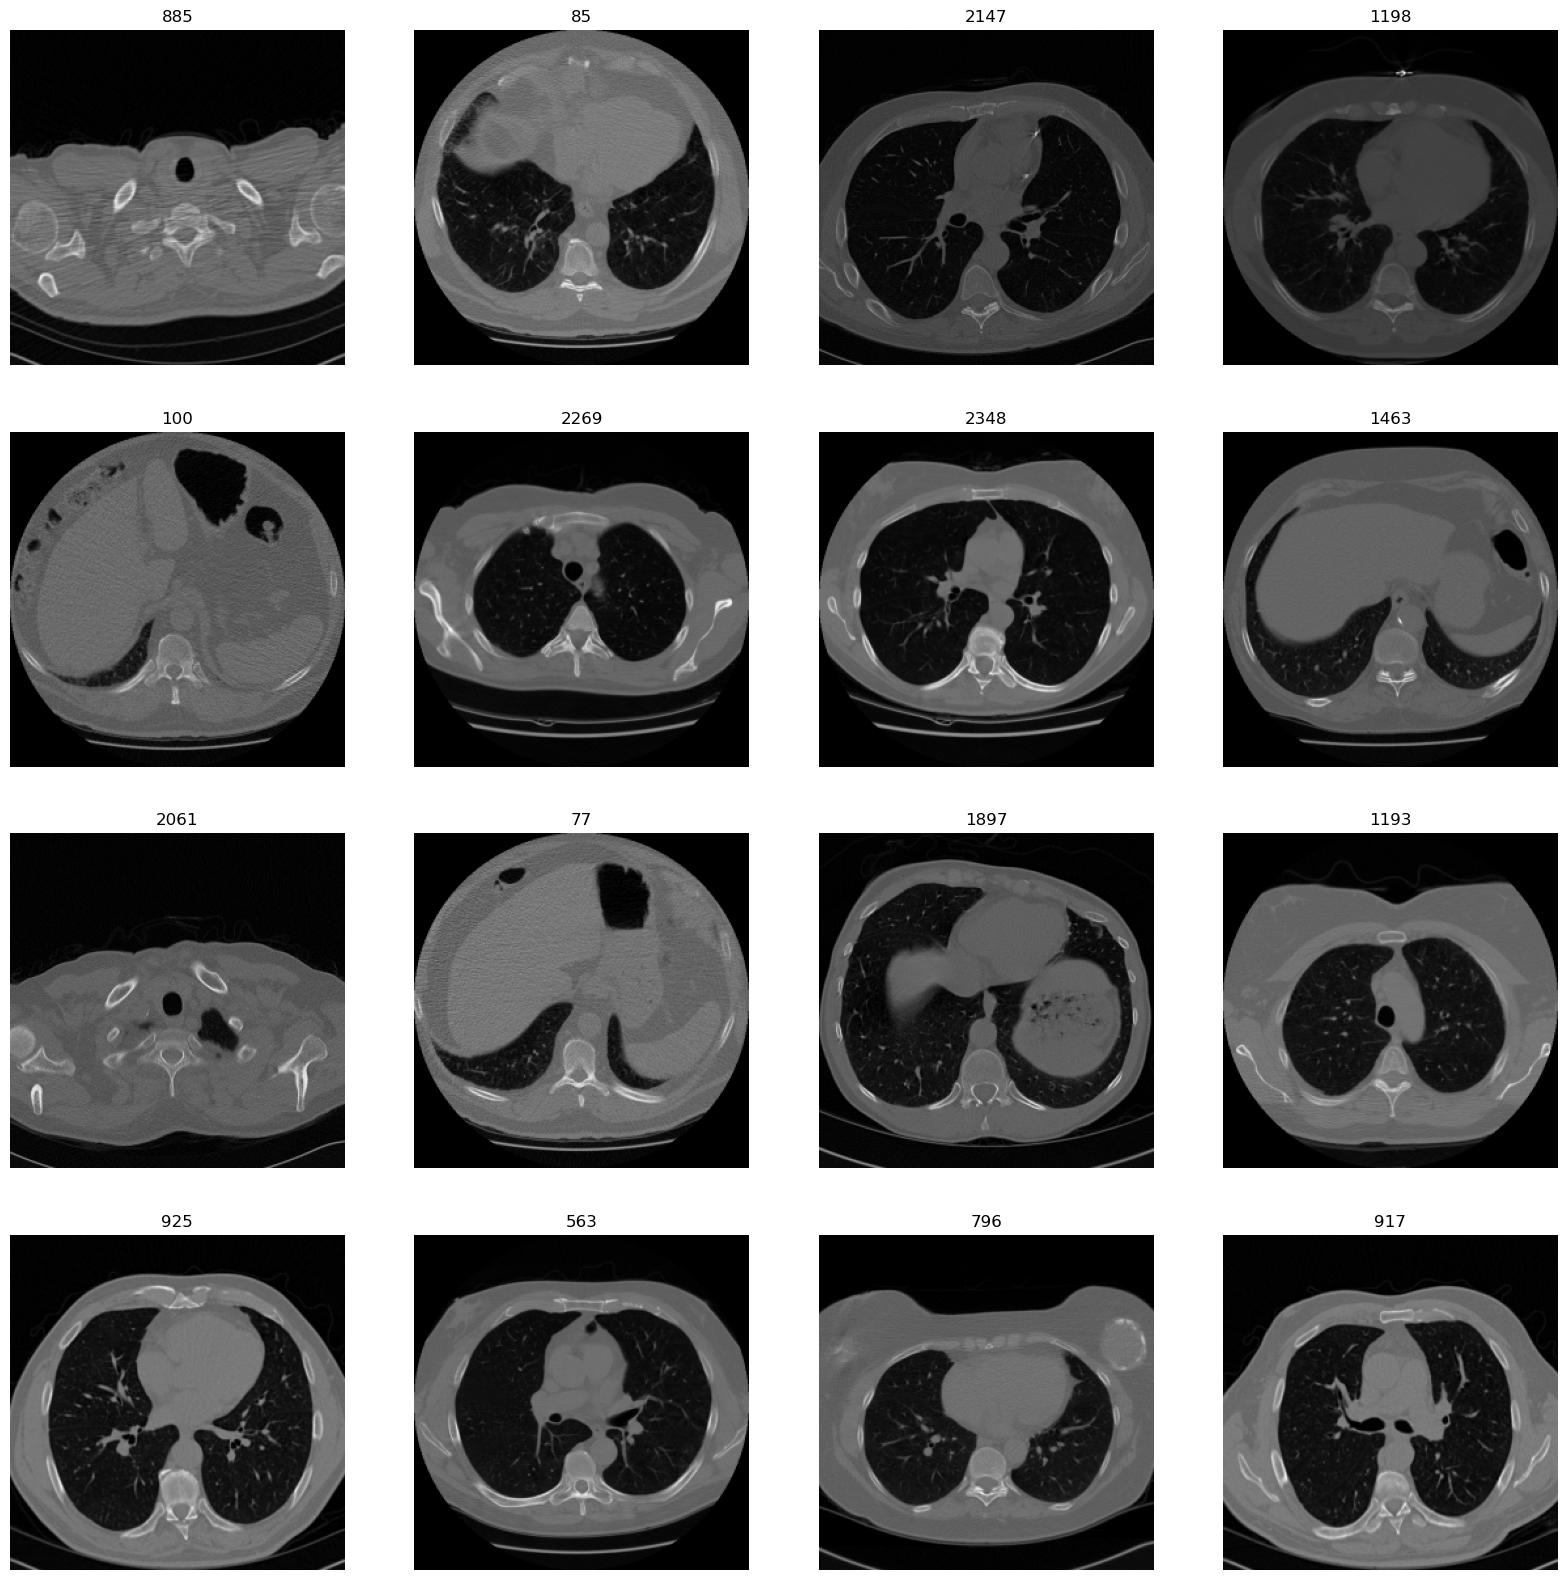

In [7]:
plt.figure(figsize=(20,20));
for n ,i in enumerate(list(np.random.randint(0,len(X_train),16))):
    plt.subplot(4,4,n+1)
    plt.imshow(X_train[i],cmap='gray')
    plt.axis('off')
    plt.title(i)

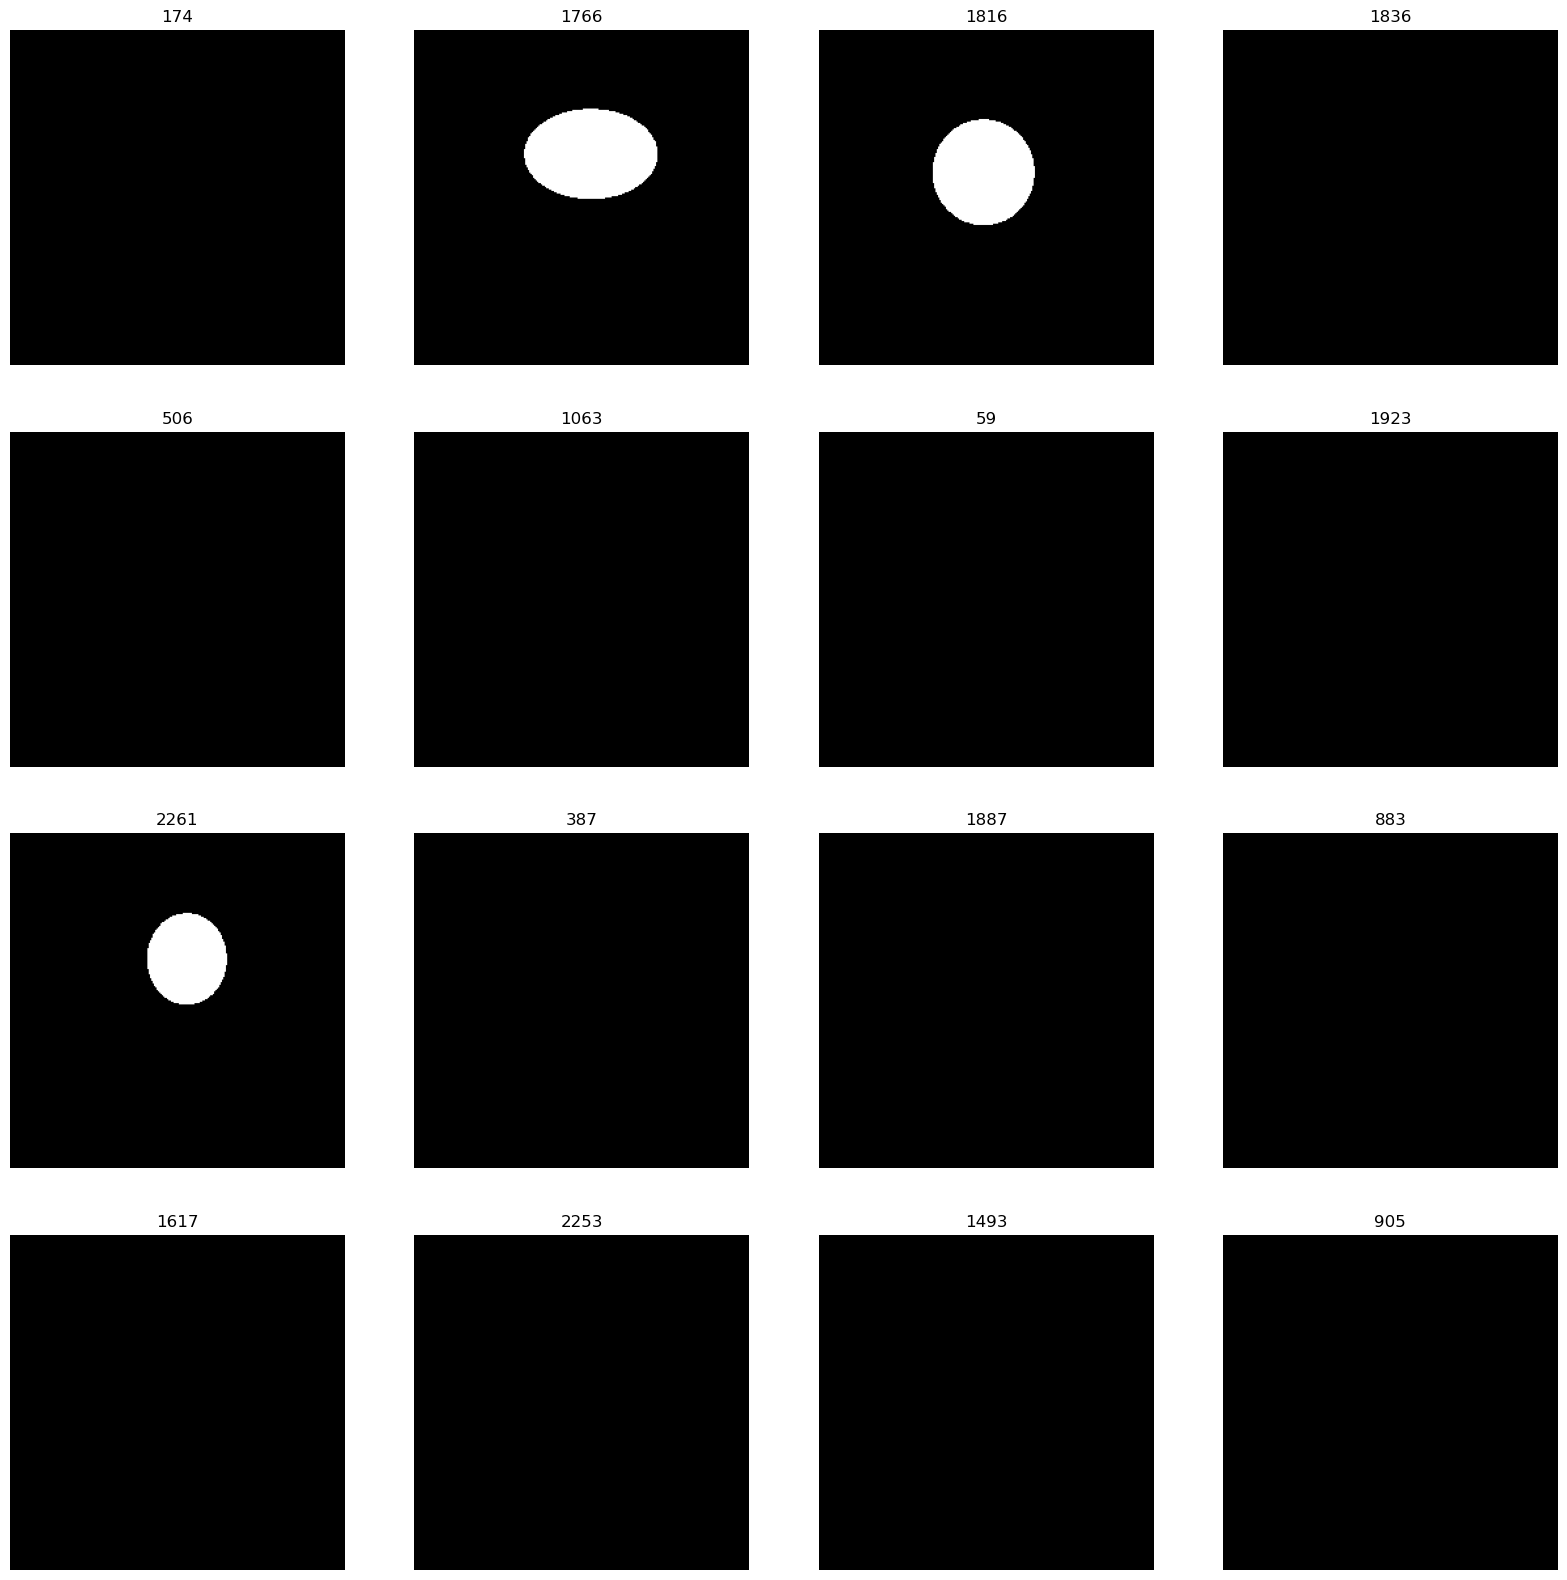

In [8]:
plt.figure(figsize=(20,20))
for n ,i in enumerate(list(np.random.randint(0,len(Y_train),16))) :
    plt.subplot(4,4,n+1)
    plt.imshow(Y_train[i],cmap='gray')
    plt.axis('off')
    plt.title(i)

In [9]:
# %pip install pydicom

In [10]:
import pydicom as dicom
from pydicom.data import get_testdata_file

In [11]:
TRAIN_PATH ='data/test/'
X_test=[]
for folder in os.listdir(TRAIN_PATH):
    files=gb.glob(TRAIN_PATH+folder+'/'+str(os.listdir(TRAIN_PATH+'/'+folder)[0])+'/*.dcm')
    for file in files :
        ds = dicom.dcmread(file)
        img = ds.pixel_array
        img = cv2.resize(img, (img_height, img_width)) 
        X_test.append(list(img))

In [12]:
X_test=np.array(X_test)

In [13]:
X_test=np.stack((X_test,)*3,axis=-1)
X_test.shape

(832, 256, 256, 3)

In [14]:
X_test = X_test/255

In [15]:
X_test=X_test.astype(np.float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

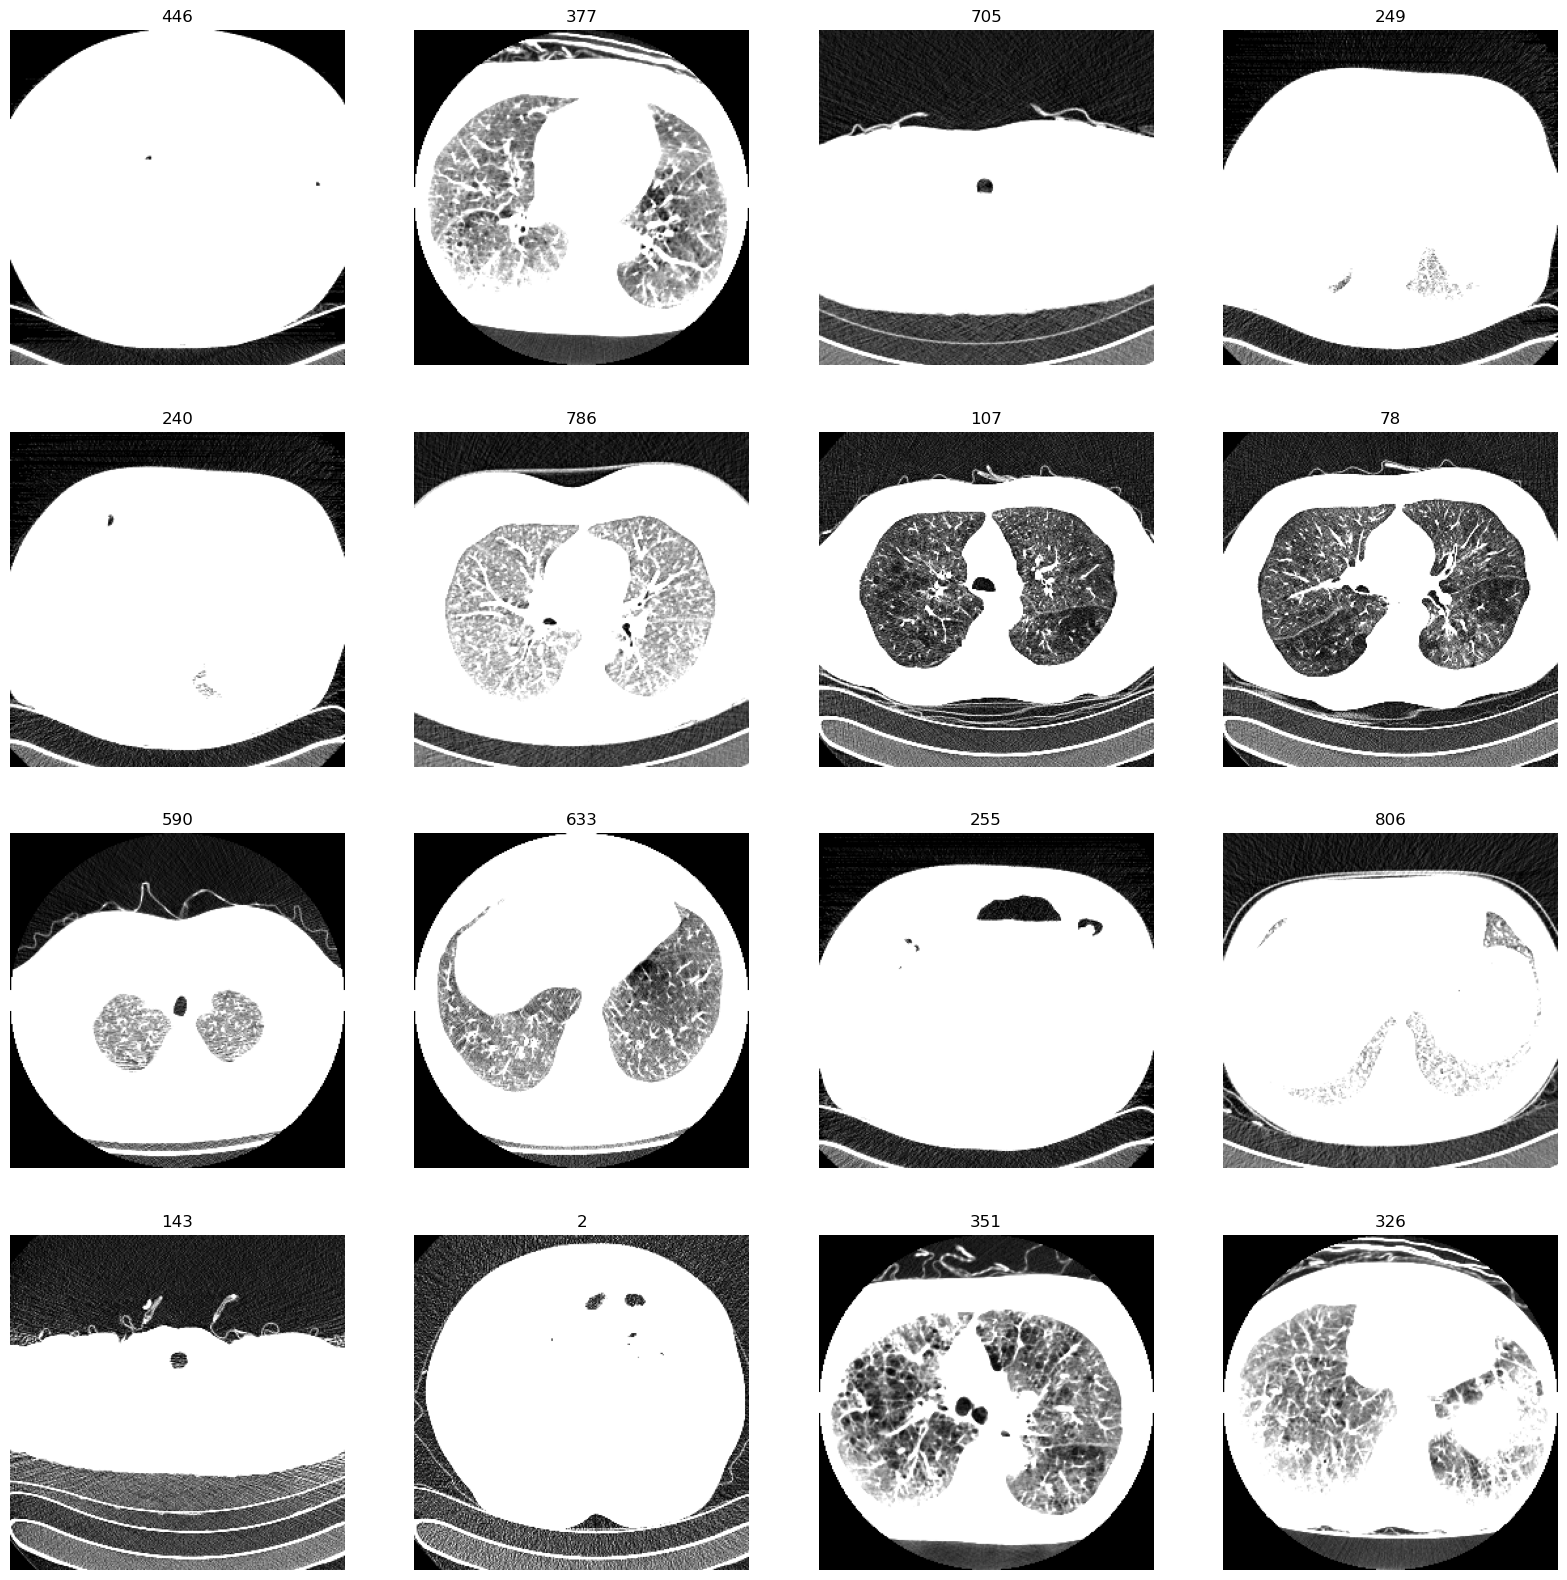

In [16]:
plt.figure(figsize=(20,20))
for n ,i in enumerate(list(np.random.randint(0,len(X_test),16))) :
    plt.subplot(4,4,n+1)
    plt.imshow(X_test[i])
    plt.axis('off')
    plt.title(i)

In [17]:
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Conv2D , MaxPooling2D ,concatenate ,Input ,Dropout ,Conv2DTranspose
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

In [18]:
# %pip install -U -q segmentation-models

In [19]:
# %pip install -U -q segmentation-models
# %pip install -q tensorflow==2.2.1
# %pip install -q keras==2.5
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

In [20]:
import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from tensorflow.keras.utils import plot_model
sm.set_framework('tf.keras')
sm.framework()
BACKBONE = 'efficientnetb2'

preprocess_input = get_preprocessing(BACKBONE)
model = Unet(BACKBONE, encoder_weights='imagenet')
#plot_model(model)

Segmentation Models: using `tf.keras` framework.


2024-02-14 17:00:33.624308: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
from tensorflow.keras.callbacks import EarlyStopping ,ReduceLROnPlateau ,ModelCheckpoint

EarlyStop=EarlyStopping(patience=10,restore_best_weights=True)
Reduce_LR=ReduceLROnPlateau(monitor='val_accuracy',verbose=2,factor=0.5,min_lr=0.00001)
model_check=ModelCheckpoint('heart_segmentation-model.h5',monitor='val_loss',verbose=1,save_best_only=True)
callback=[EarlyStop , Reduce_LR,model_check]

In [22]:
model.compile(optimizer='adam',loss=sm.losses.DiceLoss(),metrics = [tf.keras.metrics.Recall(), tf.keras.metrics.Precision(), tf.keras.metrics.AUC(),sm.metrics.iou_score,sm.metrics.FScore(threshold=0.5)])

In [23]:
history=model.fit(X_train,Y_train,validation_split=0.1,batch_size=2,steps_per_epoch=len(X_train)//32,epochs=20,
                 callbacks=callback,verbose=1)

2024-02-14 17:00:35.779188: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1791492096 exceeds 10% of free system memory.
2024-02-14 17:00:37.021716: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 597164032 exceeds 10% of free system memory.
2024-02-14 17:00:37.480390: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-02-14 17:00:37.483911: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2894655000 Hz


Epoch 1/20
79/79 [==============================] - 121s 1s/step - loss: 0.9992 - recall: 0.7570 - precision: 0.1268 - auc: 0.8434 - iou_score: 4.0333e-04 - f1-score: 0.0015 - val_loss: 0.9997 - val_recall: 1.0000 - val_precision: 0.0339 - val_auc: 0.6022 - val_iou_score: 1.3221e-04 - val_f1-score: 2.6373e-04

Epoch 00001: val_loss improved from inf to 0.99974, saving model to heart_segmentation-model.h5
Epoch 2/20
79/79 [==============================] - 110s 1s/step - loss: 0.9952 - recall: 0.5335 - precision: 0.6280 - auc: 0.8080 - iou_score: 0.0024 - f1-score: 0.0052 - val_loss: 0.9997 - val_recall: 1.0000 - val_precision: 0.0325 - val_auc: 0.5210 - val_iou_score: 1.2573e-04 - val_f1-score: 2.5160e-04

Epoch 00002: val_loss did not improve from 0.99974
Epoch 3/20
79/79 [==============================] - 111s 1s/step - loss: 0.9951 - recall: 0.2728 - precision: 0.6754 - auc: 0.7051 - iou_score: 0.0025 - f1-score: 0.0050 - val_loss: 0.9996 - val_recall: 1.0000 - val_precision: 0.0645

In [24]:
y_pred=model.predict(X_train)

2024-02-14 17:35:10.708471: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1991245824 exceeds 10% of free system memory.
2024-02-14 17:38:23.203361: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 663748608 exceeds 10% of free system memory.


In [25]:
y_pred_p=(y_pred > 0.5).astype(np.uint8)

In [28]:
import random


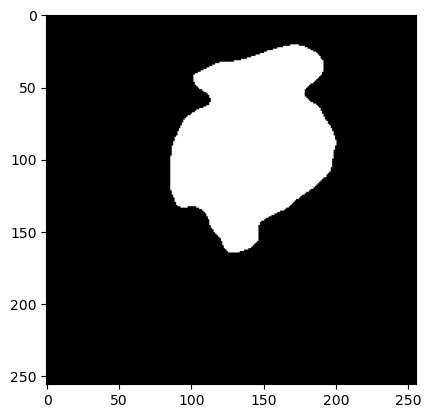

In [43]:
t = random.randint(1,300)
plt.imshow(y_pred_p[t],cmap='gray')

(-0.5, 255.5, 255.5, -0.5)

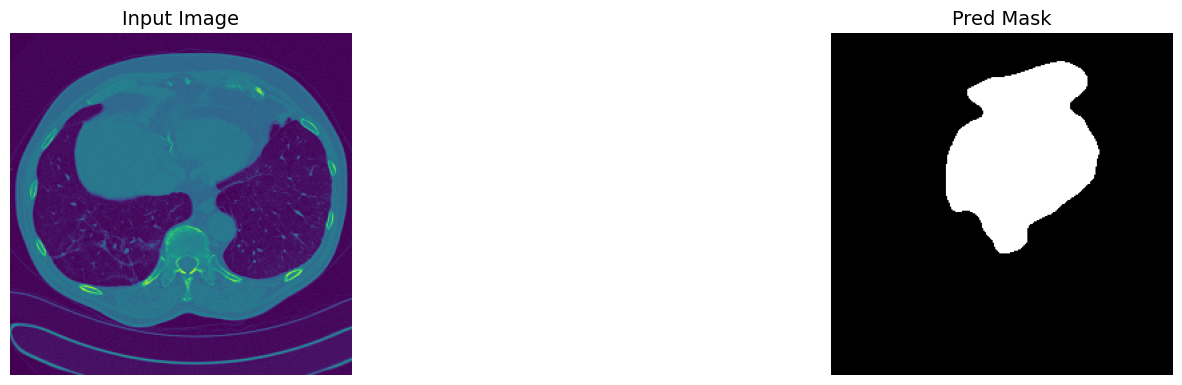

In [44]:
import random
plt.figure(figsize=(15,15))
plt.axis('Off')
# t = random.randint(1,300)
test_image = X_test[t, :, :, 0]
plt.subplot(1,3,1)
plt.imshow(test_image)
plt.title('Input Image', fontsize=14)
plt.axis('off')


test_mask = y_pred_p[t, :, :, 0]
plt.subplot(1,3,3)
plt.imshow(test_mask, cmap='gray')
plt.title('Pred Mask', fontsize=14)
plt.axis('off')